Esse notebook é uma tradução do [artigo](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-three-388834e8804b) originalmente escrito por [William Koehrsen](https://twitter.com/koehrsen_will) no site [Towards Data Science](https://towardsdatascience.com)

# Um projeto completo de aprendizado de máquina em Python - Parte 3

Os modelos de aprendizado de máquina são frequentemente criticados como [caixas-pretas](https://datascience.stackexchange.com/questions/22335/why-are-machine-learning-models-called-black-boxes): colocamos os dados de um lado e recebemos as respostas - geralmente respostas muito precisas - sem explicações do outro. Na terceira parte desta série, que mostra uma solução completa de aprendizado de máquina, veremos o modelo que desenvolvemos para tentar entender como ele faz previsões e o que pode nos ensinar sobre o problema. Vamos encerrar discutindo talvez a parte mais importante de um projeto de aprendizado de máquina: documentar nosso trabalho e apresentar resultados.

A [primeira parte](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20One.ipynb) da série cobriu a limpeza de dados, a análise exploratória de dados, a engenharia de features e a seleção de features. A [parte dois](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20Two.ipynb) cobriu a imputação de valores ausentes, implementação e comparação de modelos de aprendizado de máquina, ajuste de hiperparâmetros usando pesquisa aleatória com validação cruzada e avaliando um modelo.

Relembrando, estamos trabalhando em um problema de aprendizado de máquina de regressão supervisionada. Usando os [dados de energia de edifícios de Nova York](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml), desenvolvemos um modelo que pode prever a pontuação Energy Star de um edifício. O modelo final que construímos é um [Gradient Boosted Regressor](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), que é capaz de prever o Energy Star Score nos dados de teste com um erro de 8.5 pontos (em uma escala de 1 a 100).


# Bibliotecas

Usaremos um conjunto familiar de bibliotecas de ciência de dados e aprendizado de máquina.

In [19]:
# Pandas e Numpy para manipulação de dados
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib para visualização
import matplotlib.pyplot as plt
%matplotlib inline

# Altera o tamanho padrão da fonte
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn para visualização
import seaborn as sns

sns.set(font_scale = 2)

# Imputação de valores faltantes
from sklearn.preprocessing import Imputer, MinMaxScaler

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME para explicar as predições
import lime 
import lime.lime_tabular

# Leitura dos dados armazenados anteriormente

In [20]:
train_features = pd.read_csv('data/energy_new_york_training_features.csv')
test_features = pd.read_csv('data/energy_new_york_testing_features.csv')
train_labels = pd.read_csv('data/energy_new_york_training_labels.csv')
test_labels = pd.read_csv('data/energy_new_york_testing_labels.csv')

# Recriar o modelo final

In [21]:
# Criar um imputer com a estratégia de preenchimento pela mediana
imputer = Imputer(strategy='median')

# Treina o imputer com o conjunto de treinamento
imputer.fit(train_features)

# Transforma os dados de treino e teste
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Transformar os valores de saida para vetor unidimensional
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [22]:
# Função para calcular o erro médio absoluto MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [23]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [25]:
# Realiza as predições no conjunto de teste
model_pred = model.predict(X_test)

print('Performance do Modelo Final no conjunto de teste: MAE = %0.4f' % mae(y_test, model_pred))

Performance do Modelo Final no conjunto de teste: MAE = 9.0837


# Interpretação do Modelo

O gradient boosted regressor está em algum lugar no meio da [escala de interpretabilidade do modelo](https://2.bp.blogspot.com/-AL1LsaTHVNQ/Wh589GDwkaI/AAAAAAAAaxc/nwpqKEUIgXokRxt75nzgzQz00IRqH68PACLcBGAs/s1600/B2G1g0UIMAEieiR.png): o modelo inteiro é complexo, mas é composto de centenas de [árvores de decisão](https://en.wikipedia.org/wiki/Decision_tree_learning), que por si só são bastante compreensíveis. Vamos ver três maneiras de entender como nosso modelo faz previsões:

1. [Importâncias das features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
2. Visualizando uma única árvore de decisão
3. [LIME: Explicações de modelo agnóstico local interpretável](https://github.com/marcotcr/lime)

Os dois primeiros métodos são específicos para conjuntos de árvores, enquanto o terceiro - como você pode ter adivinhado pelo nome - pode ser aplicado a qualquer modelo de aprendizado de máquina. O LIME é um pacote relativamente novo e representa um passo empolgante no esforço contínuo para [explicar as previsões de aprendizado de máquina](https://pdfs.semanticscholar.org/ab4a/92795ee236632e6dbbe9338ae99778b57e1e.pdf).


# Importâncias das features

As importâncias de features tentam mostrar a relevância de cada feature para a tarefa de prever o destino (score). Os detalhes técnicos das importâncias de features são complexos (eles medem a [impureza média de redução](https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf) ou a [redução no erro na inclusão de feature](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)), mas podemos usar os valores relativos para comparar quais features são as mais relevantes. No Scikit-Learn, podemos [extrair as importâncias de features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) de qualquer grupo de aprendizes baseados em árvore.

Com o `model` como nosso modelo treinado, podemos encontrar as importâncias das features usando `model.feature_importances_`. Em seguida, podemos colocá-los em um DataFrame pandas e exibir ou plotar os dez primeiros mais importantes:

In [26]:
# Extraimos as importâncias das features e inserimos em um dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns),
                                'importance': model.feature_importances_})

# Mostra o top 10 das features mais importantes no modelo
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.403532
1,Weather Normalized Site Electricity Intensity ...,0.263059
2,Water Intensity (All Water Sources) (gal/ft²),0.071286
3,Property Id,0.035165
4,Largest Property Use Type_Non-Refrigerated War...,0.031924
5,DOF Gross Floor Area,0.027900
6,log_Water Intensity (All Water Sources) (gal/ft²),0.026058
7,Order,0.024592
8,log_Direct GHG Emissions (Metric Tons CO2e),0.023655
9,Year Built,0.022100


As variáveis `Site EUI` e `Weather Normalized Site Electricity Intensity` são as duas características mais importantes por uma margem bastante grande. Depois disso, a importância relativa cai consideravelmente, o que indica que talvez não seja necessário manter todas as features para criar um modelo com quase o mesmo desempenho.

Vamos plotar as importâncias para ficar mais claro e podermos comparar visualmente.

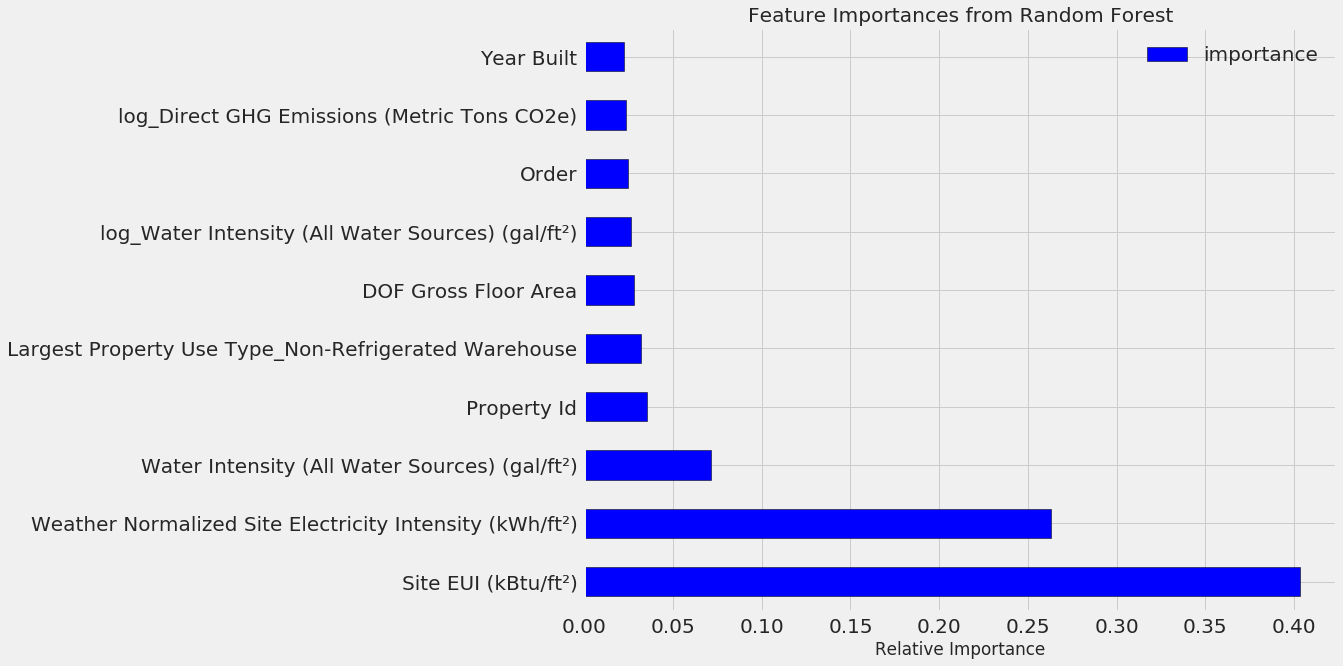

In [33]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x='feature', y='importance',
                                edgecolor='k',
                                kind='barh', color='blue')

plt.xlabel('Relative Importance')
plt.ylabel('')
plt.title('Feature Importances from Random Forest')
plt.show()